# Solving inverse problems on GPUs with Pylops+CuPy - Seismic interpolation

Welcome to the tutorial of this session! In this tutorial we will consider the problem of reconstructing missing traces in seismic data, also known as **Seismic interpolation**

By the end of the tutorial you will have learned:
- how to use more advanced PyLops operators.
- how to precondition inverse problems in PyLops
- how you can easily switch between CPU-based to GPU-based inversion;


## Create environment with PyLops+CuPy+CuSignal

In [ ]:
!git clone https://github.com/PyLops/pylops_swungrendezvous2021.git

Cloning into 'pylops_swungrendezvous2021'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 2), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [ ]:
!chmod u+x pylops_swungrendezvous2021/install.sh
!pylops_swungrendezvous2021/install.sh

--2021-01-30 16:57:28--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2021-01-30 16:57:28--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   274MB/s    in 0.2s    

2021-01-30 16:57:28 (274 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_

In [ ]:
import sys
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))

## Example: Seismic Interpolation

XXX

Let's start now by importing all useful libraries

In [ ]:
%matplotlib inline
import time
import os
import numpy as np
import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.signal import convolve
from pylops.utils import dottest
from pylops.basicoperators import Restriction
from pylops.signalprocessing import FFT2D, ChirpRadon2D, Sliding2D
from pylops.waveeqprocessing.seismicinterpolation import SeismicInterpolation
from invwidget import inversion_widget

plt.style.use('seaborn-dark')
print('cp.__version__:',  cp.__version__)

cp.__version__: 8.1.0


We can now load and display our input data

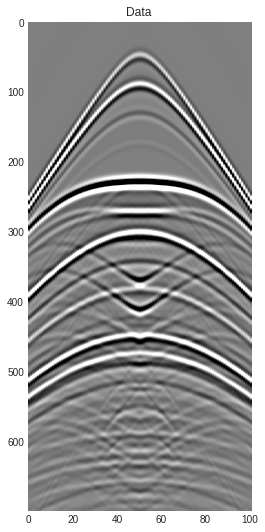

In [ ]:
inputfile = 'pylops_swungrendezvous2021/data.npz'
inputdata = np.load(inputfile, allow_pickle=True)

# Load data, time and space axes
x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
nx, nt = x.shape
dx = inputdata['r'][0, 1] - inputdata['r'][0, 0]
dt = inputdata['t'][1] - inputdata['t'][0]

# Convolve data with wavelet
wav = inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :nt]

# Apply gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, nx)).T
x *= gain

# Display data
fig, ax = plt.subplots(1, 1, figsize=(4, 9))
ax.imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
ax.set_title('Data')
ax.axis('tight');

Dot test passed, v^T(Opu)=397.795658 - u^T(Op^Tv)=397.795658


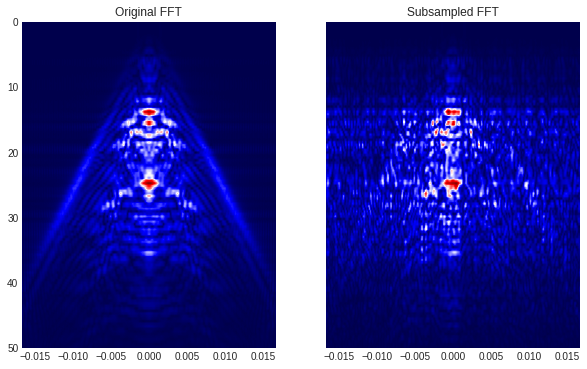

In [ ]:
# Define subsampling locations
perc_subsampling = 0.5
nxsub = int(np.round(nx * perc_subsampling))
ixava = np.sort(np.random.permutation(np.arange(nx))[:nxsub])

# Create restriction operator
Rop = Restriction(nx * nt, ixava, dims=(nx, nt), dir=0, dtype=np.float64)
dottest(Rop, nxsub * nt, nx * nt, verb=True)

# Create data
y = Rop * x.ravel()
xadj = Rop.H * y.ravel()
y = y.reshape(nxsub, nt)
xadj = xadj.reshape(nx, nt)

# Apply mask
ymask = Rop.mask(x.ravel())

# FFT of full data
nfft = 2**10
FFTop = FFT2D(dims=(nx, nt), nffts=(nfft, nfft), sampling=(dx, dt))
p = FFTop * x.ravel()
p = np.reshape(p, (nfft, nfft))

pmask = FFTop * ymask.flatten()
pmask = np.reshape(pmask, (nfft, nfft))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]), axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], 
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
axs[1].imshow(np.fft.fftshift(np.abs(pmask[:, :nfft//2-1]), axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0],
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Subsampled FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);

Dot test passed, v^T(Opu)=-1302.961460 - u^T(Op^Tv)=-1302.961460
Dot test passed, v^T(Opu)=-1388.893568 - u^T(Op^Tv)=-1388.893568
FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 35000 rows and 126000 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 400
alpha = 1.200000e-03	thresh = 3.000000e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   7.85992e-08   8.451e+00   8.472e+00   2.302e-02
     2   0.00000e+00   8.033e+00   8.073e+00   2.231e-02
     3   0.00000e+00   7.531e+00   7.595e+00   2.772e-02
     4   0.00000e+00   6.967e+00   7.060e+00   3.247e-02
     5   0.00000e+00   6.363e+00   6.488e+00   3.656e-02
     6   0.00000e+00   5.739e+00   5.900e+00   4.001e-02
     7   0.00000e+00   5.113e+00   5.311e+00   4.283e-02
     8   0.00000e+00   4.501e+00   4.739e+00   4.503e-02
     9   0.00000e+00   3.916e+00   4.194e+00   4.662e-02
 

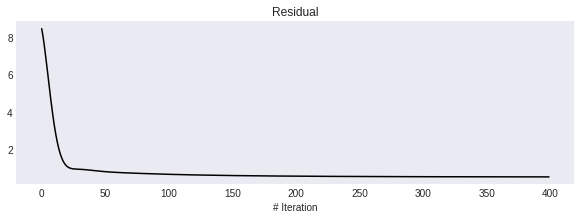

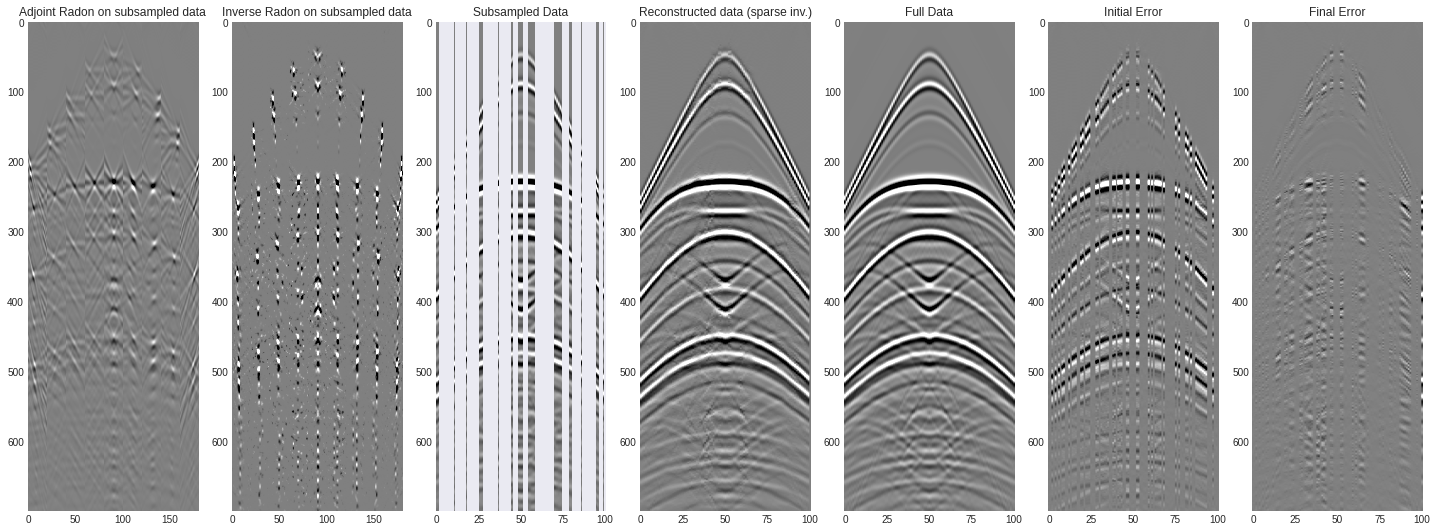

In [ ]:
# Sliding Radon operator
nwin = 20 # Size of slice in spatial direction
nwins = 9 # Number of slices
nover = 10 # Number of overlapping samples between windows
pxmax = 5e-4 # Max slowness

px = np.linspace(-pxmax, pxmax, nwin)
dimsd = x.shape
dims = (nwins*nwin, dimsd[1])
Op = ChirpRadon2D(taxis, np.linspace(-dx*nwin//2, dx*nwin//2, nwin), pxmax * dx / dt).H
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine', design=False)
dottest(Slidop, np.prod(dimsd), np.prod(dims), verb=True)

# Adjoint
Rop1 = Rop * Slidop

padj = Rop1.H * y.flatten()
padj = padj.reshape(nwin*nwins, nt)

# Inverse
def callback(x, xhistory, Pop, xshape, xtrue=None, xerror=None):
    x = cp.asnumpy(np.real(Pop * x).reshape(xshape).T)
    xhistory.append(x)
    if xtrue is not None:
        xerror.append(np.linalg.norm(x-xtrue))

xhist = []
xerror = []
xinv, pinv, cost = SeismicInterpolation(cp.asarray(y), nx, ixava, kind='sliding', spataxis=xaxis, 
                                        taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                        nover=nover, dottest=True,
                                        **dict(niter=400, eps=5e-3, alpha=1.2e-3, 
                                                returninfo=True, show=True,
                                                callback=lambda xinv: callback(xinv, xhist, Slidop, (nx, nt), x.T, xerror)))

# Visualize results
plt.figure(figsize=(10, 3))
plt.plot(cost, 'k')
plt.xlabel('# Iteration')
plt.title('Residual')

fig, axs = plt.subplots(1, 7, figsize=(25, 9))
axs[0].imshow(padj.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[0].set_title('Adjoint Radon on subsampled data')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(pinv).T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[1].set_title('Inverse Radon on subsampled data')
axs[1].axis('tight')
axs[2].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Subsampled Data')
axs[2].axis('tight');
axs[3].imshow(cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Full Data')
axs[4].axis('tight')
axs[5].imshow(ymask.data.T - cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Initial Error')
axs[5].axis('tight');
axs[6].imshow(x.T - cp.asnumpy(xinv).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[6].set_title('Final Error')
axs[6].axis('tight');

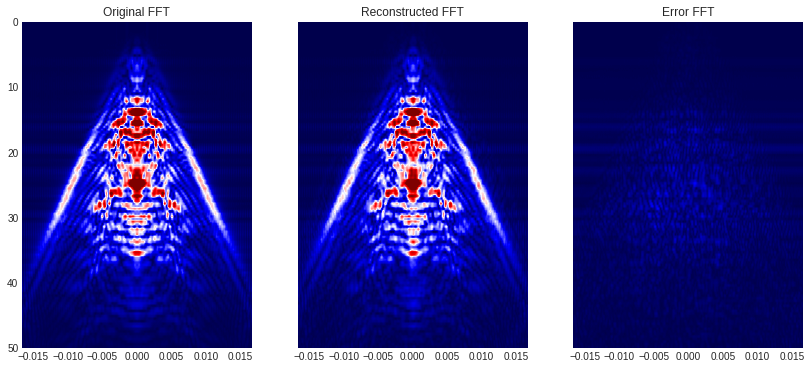

In [ ]:
# FFT of full and reconstructed data
pinv = FFTop * cp.asnumpy(xinv).flatten()
pinv = np.reshape(pinv, (nfft, nfft))

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0], 
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
axs[1].imshow(np.fft.fftshift(np.abs(pinv[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0],
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[2].imshow(np.fft.fftshift(np.abs((p-pinv)[:, :nfft//2-1]), axes=0).T, 
              cmap='seismic', vmax=0.05,
              extent=(np.fft.fftshift(FFTop.f1)[0],
                      np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[2].set_title('Error FFT')
axs[2].axis('tight')
axs[2].set_ylim(50, 0);

In [ ]:
inversion_widget(ymask.T, xhist, cost, error=np.array(xerror), model_true=x.T, title='Reconstruction Widget')

Output()

In [ ]:
# Numpy
xinv, pinv, cost = SeismicInterpolation(y, nx, ixava, kind='sliding', spataxis=xaxis, 
                                        taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                        nover=nover, dottest=True,
                                        **dict(niter=100, eps=5e-3, alpha=1.2e-3, 
                                                returninfo=True, show=True))

# Cupy
xinv, pinv, cost = SeismicInterpolation(cp.asarray(y), nx, ixava, kind='sliding', spataxis=xaxis, 
                                        taxis=taxis, paxis=px, nwins=nwins, nwin=nwin, 
                                        nover=nover, dottest=True,
                                        **dict(niter=100, eps=5e-3, alpha=1.2e-3, 
                                                returninfo=True, show=True))

Dot test passed, v^T(Opu)=559.091436 - u^T(Op^Tv)=559.091436
FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 35000 rows and 126000 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 1.200000e-03	thresh = 3.000000e-06
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   8.483e+00   8.503e+00   2.215e-02
     2  -0.00000e+00   8.093e+00   8.132e+00   2.152e-02
     3  -0.00000e+00   7.622e+00   7.685e+00   2.681e-02
     4  -0.00000e+00   7.090e+00   7.181e+00   3.149e-02
     5  -0.00000e+00   6.516e+00   6.639e+00   3.557e-02
     6  -0.00000e+00   5.919e+00   6.076e+00   3.906e-02
     7  -0.00000e+00   5.315e+00   5.508e+00   4.197e-02
     8  -0.00000e+00   4.718e+00   4.951e+00   4.430e-02
     9  -0.00000e+00   4.142e+00   4.415e+00   4.607e-02
    10  -0.00000e+00   3.596e+00   3.910e+00   4.730e-02
    11  -0.00

TO DO!!!

- Finish text description
- Comment invwidget code (and also save to repo and back to pylops_notebook repo too)
- Try adding fk patching